This notebook is derived from 04_DE_by_plasmid.ipynb. The purpose is to generate plots with dual guides side by side in a single panel.

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
}))
options(timeout=100)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 150 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen2"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs9529913,DE24-2a,DE24-2b,DE24,ckd_de,targeting,rs9529913,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE
C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
rs881858,DE9-2a,DE9-2b,DE9,ckd_de,targeting,rs881858,CKD DE


In [7]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [8]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [9]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## FeaturePlot singlet & doublet

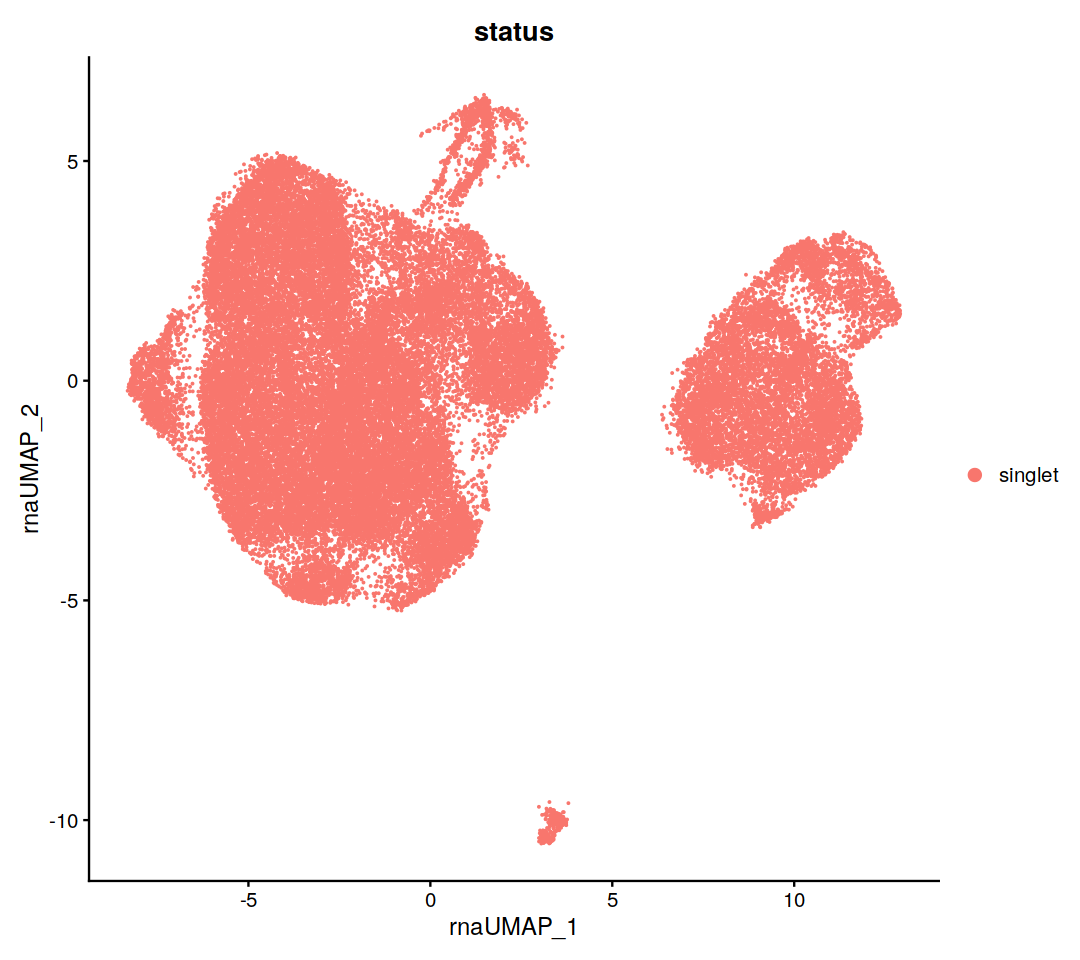

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Differential expression

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide <- get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds) 
length(perturbed_cells_by_guide[[3]])

[1] 301

In [13]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

In [14]:
# This function is not necessary. Using mark_target_pos_neg()
# Mark cells that are positive for given guides as target_positive, all others as target_negative
mark_plasmid_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)    
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "plasmid_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "plasmid_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Plasmid+ =",n_gplus, "; Plasmid- =", n_gminus, "\n"))
    }
    
    seurat_obj
}


### Applications

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [15]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

CD13-1a   390 
CD55-1a   684 
CD73-1a   1013 
FUBP1-1a   1229 
C15orf40-1a   1574 
MAFF-1a   1837 
FTH1-1a   2011 
FTH1-2a   3255 
PLIN3-1a   3518 
PLIN3-2a   3741 
TKT-1a   4023 
TKT-2a   4261 
LGALS3-1a   4559 
LGALS3-2a   4778 
CSTB-1a   5066 
CSTB-2a   5351 
CTSB-1a   5583 
CTSB-2a   5801 
KLF6-1a   6006 
KLF6-2a   6260 
DE1-1a   6487 
DE1-2a   6686 
DE2-1a   6686 
DE2-2a   6926 
DE3-1a   7135 
DE3-2a   7345 
DE4-1a   7908 
DE4-2a   8088 
DE5-1a   8293 
DE5-2a   8520 
DE6-1a   8709 
DE6-2a   9184 
DE7-1a   9451 
DE7-2a   9581 
DE8-1a   9779 
DE8-2a   9940 
DE9-1a   10093 
DE9-2a   10093 
DE10-1a   10241 
DE10-2a   10349 
DE11-1a   10499 
DE11-2a   10609 
DE12-1a   10762 
DE12-2a   10843 
DE13-1a   10946 
DE13-2a   11011 
DE14-1a   11141 
DE14-2a   11246 
DE15-1a   11357 
DE15-2a   11498 
DE16-1a   11587 
DE16-2a   11587 
DE17-1a   11699 
DE17-2a   11858 
DE18-1a   12547 
DE18-2a   12799 
DE19-1a   12880 
DE19-2a   13162 
DE20-1a   13406 
DE20-2a   13723 
DE21-1a   13835 
DE21-2a   

# <font color='yellow'> DE for all Targeting Guide pairs </font> 

Load the neighbors of the targets first

In [16]:
library("rlist")
neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")


Attaching package: 'rlist'


The following object is masked from 'package:S4Vectors':

    List




In [17]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [18]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_targeting = filter(df_guide, class=='targeting')
#df_targeting = filter(df_guide, subclass=='ckd_de')
df_neighbor_de = NULL
test_use = "LR" #"MAST" #"wilcox" 
genes_to_skip = c("DE5", "CD55", "CSTB")
genes_to_skip = c()
lfc_threshold = 0.20
n_tests = 0
pos_label = "target_positive"
neg_label = "target_negative"



for(i in 1:nrow(df_targeting)) {
    target = df_targeting[i, 'alias']
    target_subclass = df_targeting[i, 'subclass']
    gene_or_rsid = df_targeting[i, 'gene_or_rsid']

    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }

    neighbors = neighbors_list[[gene_or_rsid]]
    n_tests = n_tests + length(neighbors)
    guides_on_plasmid = unlist(as.list(t(df_targeting[i, c('guide1', 'guide2')])))
    cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,        
        perturbed_cells_by_guide, 
        guides_on_plasmid,
        print_counts = T,
        pos_label = pos_label,
        neg_label = neg_label
    )

    if(pos_label %in% levels((Idents(seurat_dummy)))) {
        markers <- FindMarkers(
            object = seurat_dummy,
            features = neighbors,
            slot = "data",
            ident.1 = pos_label,
            ident.2 = neg_label,
            test.use = test_use,
            logfc.threshold = lfc_threshold,
            latent.vars = c('library'),
            only.pos = FALSE, 
            verbose = TRUE
        )
        print("FM complete"); flush.console();
        # latent.vars = c("library", "donor"),
        # latent.vars = c('library') 
        if(nrow(markers) == 0) {
            cat(red("No DE genes", target,  "\n"))
            flush.console()
            next
        } 
        markers$de_gene = rownames(markers)
        markers$target = target
        markers$subclass = target_subclass
        markers$plasmid = gsub("a", "", guides_on_plasmid[[1]])
        markers$label = df_targeting[i, 'label']
        rownames(markers) <- NULL
        df_neighbor_de = rbind(df_neighbor_de, markers)
        
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
    flush.console()
}

ANPEP : CD13-1a,CD13-1b 
CD13-1a   390 
CD13-1b   564 
Guide+ = 564 ; Guide- = 45487 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes ANPEP 
CD55 : CD55-1a,CD55-1b 
CD55-1a   301 
CD55-1b   466 
Guide+ = 466 ; Guide- = 45585 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes CD55 
NT5E : CD73-1a,CD73-1b 
CD73-1a   344 
CD73-1b   474 
Guide+ = 474 ; Guide- = 45577 
[1] "FM complete"
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   234 
FUBP1-1b   372 
Guide+ = 372 ; Guide- = 45679 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes FUBP1 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   377 
C15orf40-1b   526 
Guide+ = 526 ; Guide- = 45525 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes C15orf40 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   295 
MAFF-1b   406 
Guide+ = 406 ; Guide- = 45645 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes MAFF 
FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   203 
FTH1-1b   289 
Guide+ = 289 ; Guide- = 45762 
[1] "FM complete"
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   1423 
FTH1-2b   1423 
Guide+ = 1423 ; Guide- = 44628 
[1] "FM complete"
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   333 
PLIN3-1b   507 
Guide+ = 507 ; Guide- = 45544 
[1] "FM complete"
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   276 
PLIN3-2b   397 
Guide+ = 397 ; Guide- = 45654 
[1] "FM complete"
TKT : TKT-1a,TKT-1b 
TKT-1a   360 
TKT-1b   516 
Guide+ = 516 ; Guide- = 45535 
[1] "FM complete"
TKT : TKT-2a,TKT-2b 
TKT-2a   300 
TKT-2b   428 
Guide+ = 428 ; Guide- = 45623 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes TKT 
LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   397 
LGALS3-1b   509 
Guide+ = 509 ; Guide- = 45542 
[1] "FM complete"
LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   313 
LGALS3-2b   408 
Guide+ = 408 ; Guide- = 45643 
[1] "FM complete"
CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   417 
CSTB-1b   547 
Guide+ = 547 ; Guide- = 45504 
[1] "FM complete"
CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   405 
CSTB-2b   492 
Guide+ = 492 ; Guide- = 45559 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes CSTB 
CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   337 
CTSB-1b   459 
Guide+ = 459 ; Guide- = 45592 
[1] "FM complete"
CTSB : CTSB-2a,CTSB-2b 
CTSB-2a   325 
CTSB-2b   422 
Guide+ = 422 ; Guide- = 45629 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes CTSB 
KLF6 : KLF6-1a,KLF6-1b 
KLF6-1a   336 
KLF6-1b   448 
Guide+ = 448 ; Guide- = 45603 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes KLF6 
KLF6 : KLF6-2a,KLF6-2b 
KLF6-2a   390 
KLF6-2b   499 
Guide+ = 499 ; Guide- = 45552 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes KLF6 
DE1 : DE1-1a,DE1-1b 
DE1-1a   342 
DE1-1b   450 
Guide+ = 450 ; Guide- = 45601 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE1 
DE1 : DE1-2a,DE1-2b 
DE1-2a   364 
DE1-2b   472 
Guide+ = 472 ; Guide- = 45579 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE1 
DE2 : DE2-1a,DE2-1b 
DE2-1a   0 
DE2-1b   0 
Guide+ = 0 ; Guide- = 46051 
No cells found: DE2-1a,DE2-1b 
DE2 : DE2-2a,DE2-2b 
DE2-2a   425 
DE2-2b   637 
Guide+ = 637 ; Guide- = 45414 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE2 
DE3 : DE3-1a,DE3-1b 
DE3-1a   348 
DE3-1b   485 
Guide+ = 485 ; Guide- = 45566 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE3 
DE3 : DE3-2a,DE3-2b 
DE3-2a   366 
DE3-2b   566 
Guide+ = 566 ; Guide- = 45485 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE3 
DE4 : DE4-1a,DE4-1b 
DE4-1a   904 
DE4-1b   904 
Guide+ = 904 ; Guide- = 45147 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE4 
DE4 : DE4-2a,DE4-2b 
DE4-2a   334 
DE4-2b   431 
Guide+ = 431 ; Guide- = 45620 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE4 
DE5 : DE5-1a,DE5-1b 
DE5-1a   391 
DE5-1b   594 
Guide+ = 594 ; Guide- = 45457 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE5 
DE5 : DE5-2a,DE5-2b 
DE5-2a   418 
DE5-2b   648 
Guide+ = 648 ; Guide- = 45403 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE5 
DE6 : DE6-1a,DE6-1b 
DE6-1a   350 
DE6-1b   552 
Guide+ = 552 ; Guide- = 45499 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE6 
DE6 : DE6-2a,DE6-2b 
DE6-2a   928 
DE6-2b   928 
Guide+ = 928 ; Guide- = 45123 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE6 
DE7 : DE7-1a,DE7-1b 
DE7-1a   488 
DE7-1b   593 
Guide+ = 593 ; Guide- = 45458 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE7 
DE7 : DE7-2a,DE7-2b 
DE7-2a   296 
DE7-2b   385 
Guide+ = 385 ; Guide- = 45666 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE7 
DE8 : DE8-1a,DE8-1b 
DE8-1a   425 
DE8-1b   577 
Guide+ = 577 ; Guide- = 45474 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE8 
DE8 : DE8-2a,DE8-2b 
DE8-2a   364 
DE8-2b   571 
Guide+ = 571 ; Guide- = 45480 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE8 
DE9 : DE9-1a,DE9-1b 
DE9-1a   356 
DE9-1b   582 
Guide+ = 582 ; Guide- = 45469 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE9 
DE9 : DE9-2a,DE9-2b 
DE9-2a   0 
DE9-2b   0 
Guide+ = 0 ; Guide- = 46051 
No cells found: DE9-2a,DE9-2b 
DE10 : DE10-1a,DE10-1b 
DE10-1a   321 
DE10-1b   403 
Guide+ = 403 ; Guide- = 45648 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE10 
DE10 : DE10-2a,DE10-2b 
DE10-2a   257 
DE10-2b   387 
Guide+ = 387 ; Guide- = 45664 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE10 
DE11 : DE11-1a,DE11-1b 
DE11-1a   353 
DE11-1b   456 
Guide+ = 456 ; Guide- = 45595 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE11 
DE11 : DE11-2a,DE11-2b 
DE11-2a   275 
DE11-2b   384 
Guide+ = 384 ; Guide- = 45667 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE11 
DE12 : DE12-1a,DE12-1b 
DE12-1a   342 
DE12-1b   496 
Guide+ = 496 ; Guide- = 45555 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE12 
DE12 : DE12-2a,DE12-2b 
DE12-2a   223 
DE12-2b   379 
Guide+ = 379 ; Guide- = 45672 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE12 
DE13 : DE13-1a,DE13-1b 
DE13-1a   281 
DE13-1b   281 
Guide+ = 281 ; Guide- = 45770 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE13 
DE13 : DE13-2a,DE13-2b 
DE13-2a   193 
DE13-2b   334 
Guide+ = 334 ; Guide- = 45717 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE13 
DE14 : DE14-1a,DE14-1b 
DE14-1a   329 
DE14-1b   447 
Guide+ = 447 ; Guide- = 45604 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE14 
DE14 : DE14-2a,DE14-2b 
DE14-2a   291 
DE14-2b   398 
Guide+ = 398 ; Guide- = 45653 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE14 
DE15 : DE15-1a,DE15-1b 
DE15-1a   278 
DE15-1b   381 
Guide+ = 381 ; Guide- = 45670 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE15 
DE15 : DE15-2a,DE15-2b 
DE15-2a   385 
DE15-2b   606 
Guide+ = 606 ; Guide- = 45445 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE15 
DE16 : DE16-1a,DE16-1b 
DE16-1a   267 
DE16-1b   404 
Guide+ = 404 ; Guide- = 45647 
[1] "FM complete"
DE16 : DE16-2a,DE16-2b 
DE16-2a   0 
DE16-2b   287 
Guide+ = 287 ; Guide- = 45764 
[1] "FM complete"
DE17 : DE17-1a,DE17-1b 
DE17-1a   305 
DE17-1b   423 
Guide+ = 423 ; Guide- = 45628 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "FM complete"
No DE genes DE17 
DE17 : DE17-2a,DE17-2b 
DE17-2a   373 
DE17-2b   462 
Guide+ = 462 ; Guide- = 45589 
[1] "FM complete"
DE18 : DE18-1a,DE18-1b 
DE18-1a   1412 
DE18-1b   1946 
Guide+ = 1946 ; Guide- = 44105 
[1] "FM complete"
DE18 : DE18-2a,DE18-2b 
DE18-2a   660 
DE18-2b   905 
Guide+ = 905 ; Guide- = 45146 
[1] "FM complete"
DE19 : DE19-1a,DE19-1b 
DE19-1a   244 
DE19-1b   329 
Guide+ = 329 ; Guide- = 45722 
[1] "FM complete"
DE19 : DE19-2a,DE19-2b 
DE19-2a   845 
DE19-2b   1203 
Guide+ = 1203 ; Guide- = 44848 
[1] "FM complete"
DE20 : DE20-1a,DE20-1b 
DE20-1a   789 
DE20-1b   1039 
Guide+ = 1039 ; Guide- = 45012 
[1] "FM complete"
DE20 : DE20-2a,DE20-2b 
DE20-2a   915 
DE20-2b   1214 
Guide+ = 1214 ; Guide- = 44837 
[1] "FM complete"
DE21 : DE21-1a,DE21-1b 
DE21-1a   370 
DE21-1b   536 
Guide+ = 536 ; Guide- = 45515 
[1] "FM complete"
DE21 : DE21-2a,DE21-2b 
DE21-2a   784 
DE21-2b   1133 
Guide+ = 1133 ; Guide- = 44918 
[1] "FM complete"
DE22 : DE22-1a,DE22-1b 
DE

### Correct p-values by total number of comparisons

In [ ]:
#n_tests = length(flatten(neighbors_list)) * length(df_targeting)
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 1297


Write to file

In [ ]:
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_UNFILTERED.tsv")
write.table(df_neighbor_de, de_f_name, sep="\t", quote = F, row.names = F)

### Filter out spurious hits

In [ ]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
# No need for filtering when you're testing diffex over neighbors
#funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
#df_neighbor_de = filter(df_neighbor_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_FILTERED.tsv")
write.table(df_neighbor_de, de_f_name, sep="\t", quote = F, row.names = F)

# Inpect DE results

In [ ]:
de_f_name
df_neighbor_de = read.table(de_f_name, sep="\t",  header = T)

[1] "/home/vsevim/prj/1012-ckd/S2/analysis/secondary//integrated/DE_outputs/DE_genes_by_plasmid_LFC_0_03_FILTERED.tsv"

Print top high-confidence hits

In [ ]:
df_top_hits <- df_neighbor_de %>% filter(avg_log2FC < 0) %>% arrange(p_val_adj) %>% head(40)

tb <- ggtexttable(df_top_hits, theme= ttheme(base_size = 16)) %>% tab_add_title(text = "Split-by-plasmid diff ex", face = "plain", size = 18)
options(repr.plot.width=14, repr.plot.height=14)
print(tb)

ERROR: Error in data.frame(fg_params, label = as.vector(label_matrix), stringsAsFactors = FALSE): arguments imply differing number of rows: 1, 0


In [ ]:
df_neighbor_de

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.4e-15,0.33,0.85,0.73,8.8e-11,SNHG5,NT5E,tss,CD73-1,Control TSS,3.1e-12
2.3e-12,0.28,0.99,0.98,8.3e-08,RPL36,PLIN3,de_control,PLIN3-2,Control DE,3.0e-09
8.9e-11,0.37,0.92,0.86,3.3e-06,LGALS3,LGALS3,de_control,LGALS3-1,Control DE,1.2e-07
1.4e-08,0.27,0.92,0.87,5.3e-04,LGALS3,LGALS3,de_control,LGALS3-2,Control DE,1.9e-05
2.1e-15,0.28,1.00,0.96,7.6e-11,CTSB,CTSB,de_control,CTSB-1,Control DE,2.7e-12


# Visualize Knockdowns

## TSS controls

ANPEP : CD13-1a,CD13-1b 
CD13-1a   390 
CD13-1b   564 
Guide+ = 564 ; Guide- = 45487 
CD55 : CD55-1a,CD55-1b 
CD55-1a   301 
CD55-1b   466 
Guide+ = 466 ; Guide- = 45585 
NT5E : CD73-1a,CD73-1b 
CD73-1a   344 
CD73-1b   474 
Guide+ = 474 ; Guide- = 45577 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   234 
FUBP1-1b   372 
Guide+ = 372 ; Guide- = 45679 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   377 
C15orf40-1b   526 
Guide+ = 526 ; Guide- = 45525 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   295 
MAFF-1b   406 
Guide+ = 406 ; Guide- = 45645 


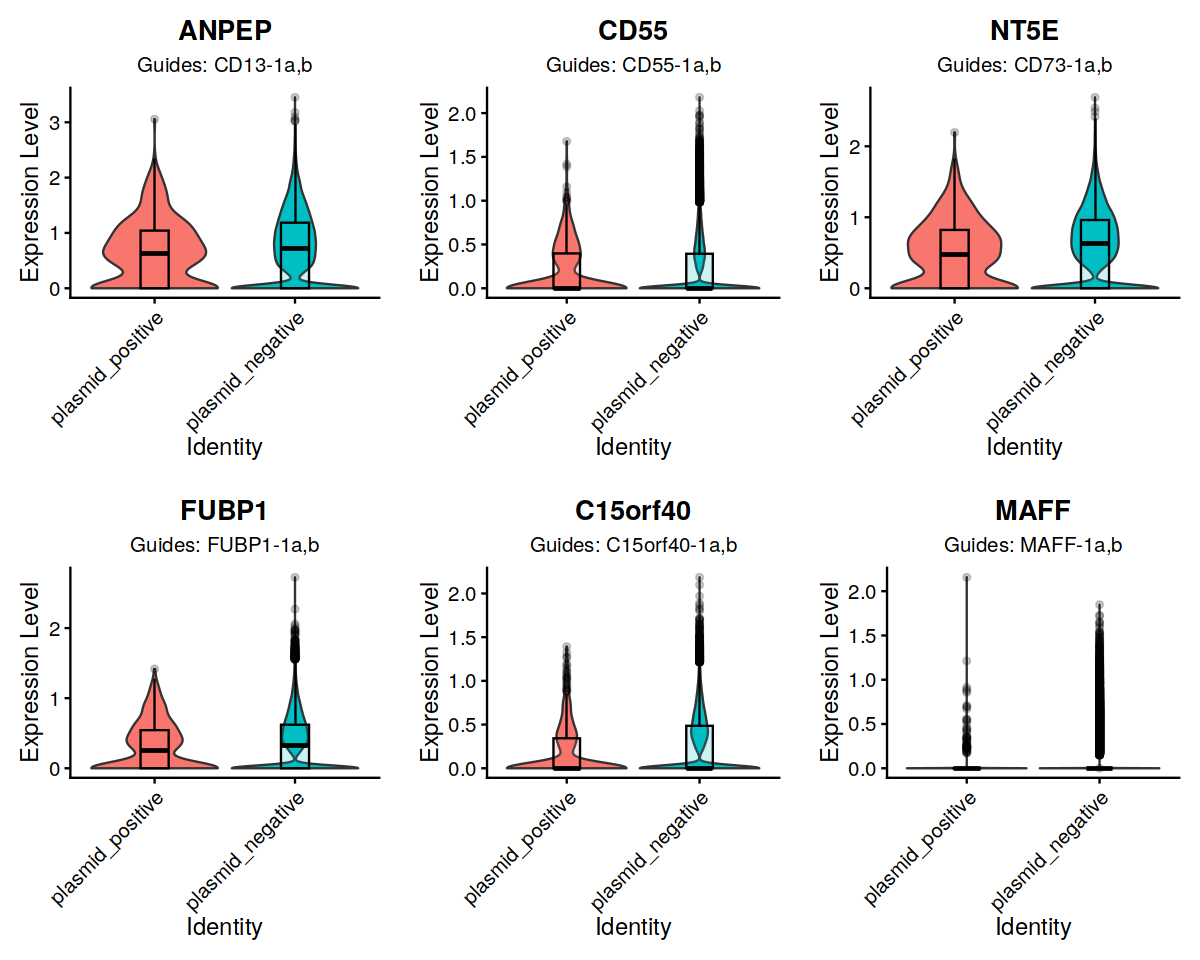

In [ ]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_tss = filter(df_guide, subclass=='tss')
plots = vlnplot_for_plasmids(seurat_rna, df_tss, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   203 
FTH1-1b   289 
Guide+ = 289 ; Guide- = 45762 
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   1423 
FTH1-2b   1423 
Guide+ = 1423 ; Guide- = 44628 
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   333 
PLIN3-1b   507 
Guide+ = 507 ; Guide- = 45544 
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   276 
PLIN3-2b   397 
Guide+ = 397 ; Guide- = 45654 
TKT : TKT-1a,TKT-1b 
TKT-1a   360 
TKT-1b   516 
Guide+ = 516 ; Guide- = 45535 
TKT : TKT-2a,TKT-2b 
TKT-2a   300 
TKT-2b   428 
Guide+ = 428 ; Guide- = 45623 
LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   397 
LGALS3-1b   509 
Guide+ = 509 ; Guide- = 45542 
LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   313 
LGALS3-2b   408 
Guide+ = 408 ; Guide- = 45643 
CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   417 
CSTB-1b   547 
Guide+ = 547 ; Guide- = 45504 
CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   405 
CSTB-2b   492 
Guide+ = 492 ; Guide- = 45559 
CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   337 
CTSB-1b   459 
Guide+ = 459 ; Guide- = 45592 
CTSB : CTSB-2a,CTSB-2b 
CTSB-2a   325 
CTS

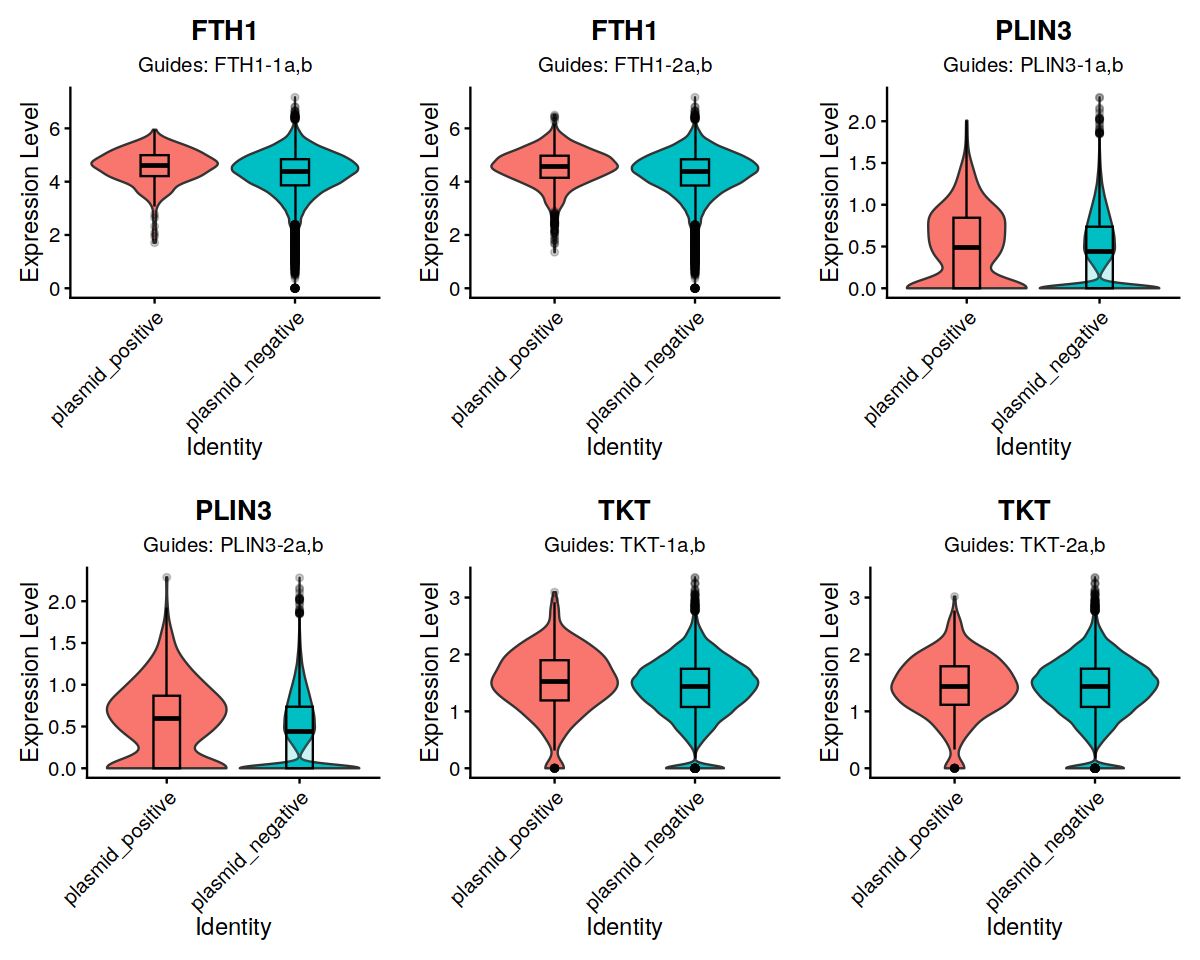

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

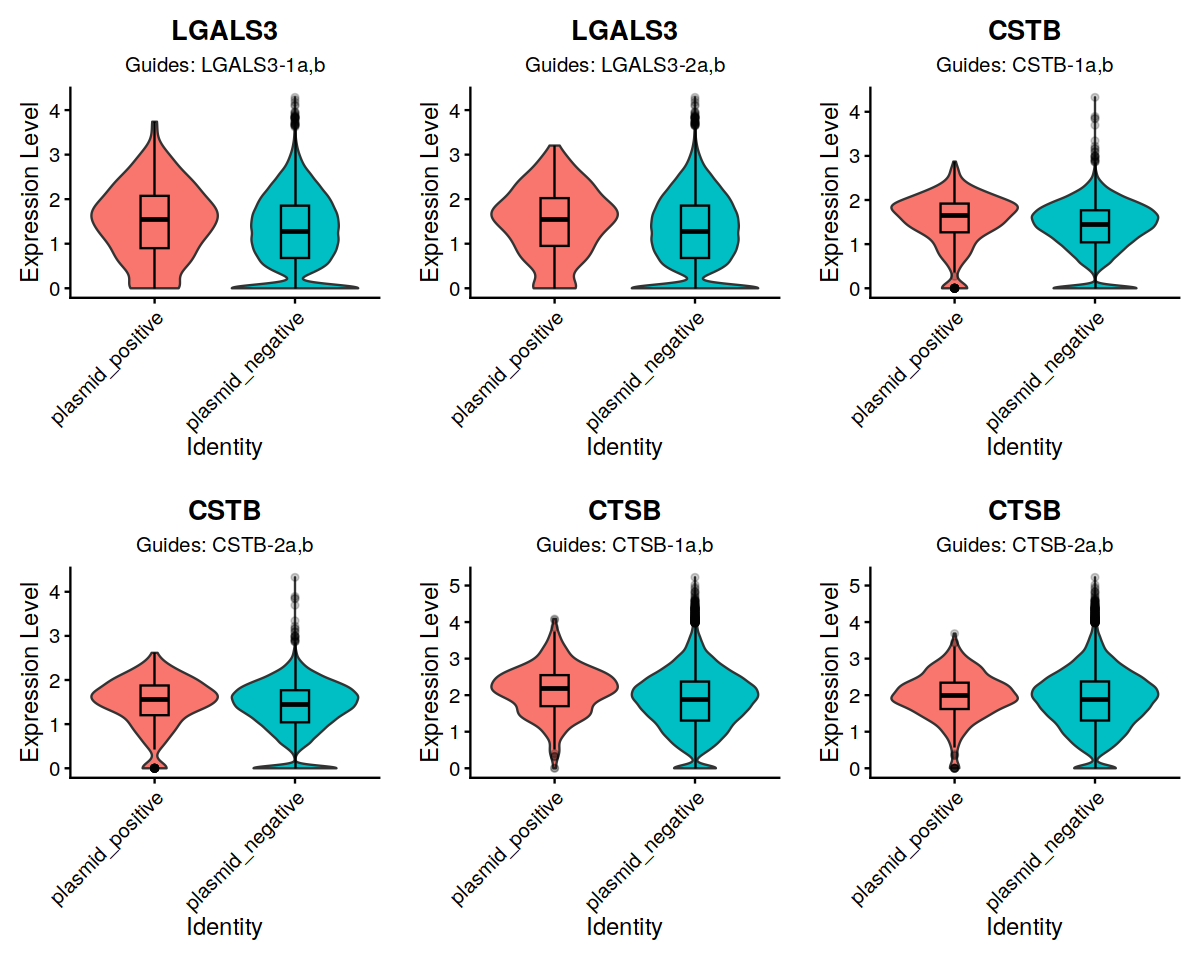

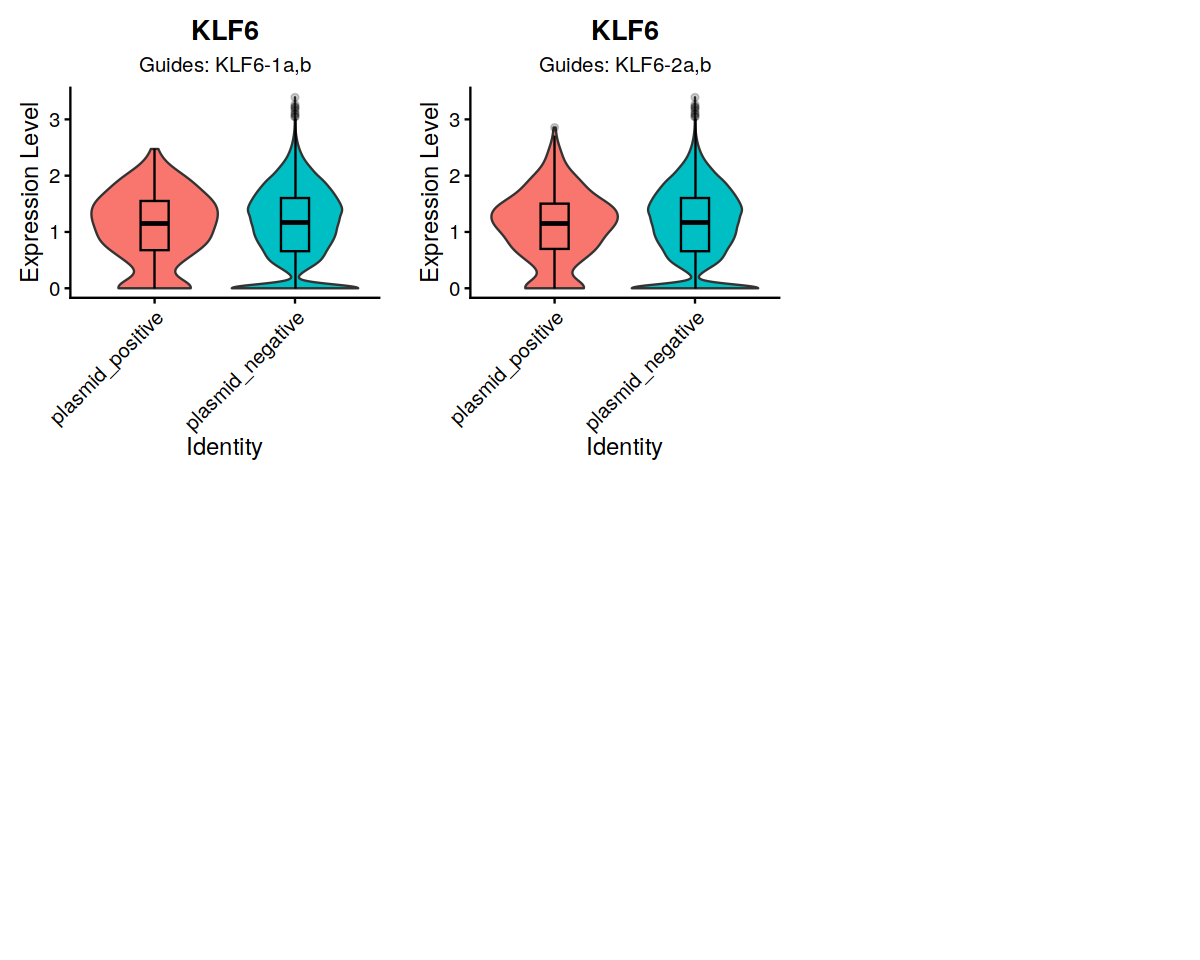

In [ ]:
df_neighbor_de_control = filter(df_guide, subclass=='de_control')
plots = vlnplot_for_plasmids(seurat_rna, df_neighbor_de_control, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## CKD DE 

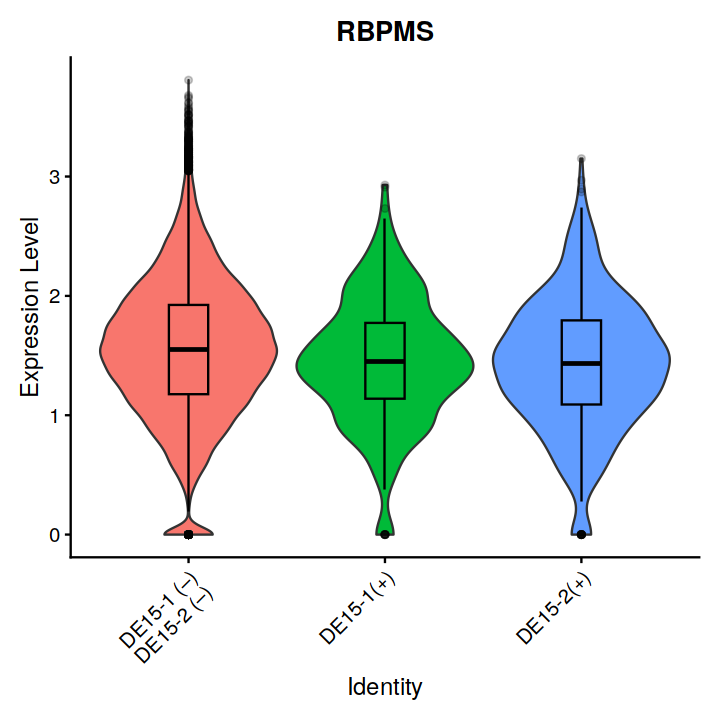

In [ ]:
# plasmid_1  = c("DE6-1a", "DE6-1b") 
# plasmid_2  = c("DE6-2a", "DE6-2b")
# plasmid_labels = c("DE6-1", "DE6-2")
# target_gene = "NDRG1"

plasmid_1  = c("DE15-1a", "DE15-1b") 
plasmid_2  = c("DE15-2a", "DE15-2b")
plasmid_labels = c("DE15-1", "DE15-2")
target_gene = "RBPMS"

# plasmid_1  = c("FTH1-1a", "FTH1-1b") 
# plasmid_2  = c("FTH1-2a", "FTH1-2b")
# plasmid_labels = c("FTH1-1", "FTH1-2")
# target_gene = 'FTH1'

plasmid_1_cells = union(
                    perturbed_cells_by_guide[[plasmid_1[[1]]]], 
                    perturbed_cells_by_guide[[plasmid_1[[2]]]]
                )

plasmid_2_cells = union(
                    perturbed_cells_by_guide[[plasmid_2[[1]]]], 
                    perturbed_cells_by_guide[[plasmid_2[[2]]]]
                )

common_cells = intersect(plasmid_1_cells, plasmid_2_cells)
all_cells    = Cells(seurat_rna)
usable_cells = setdiff(all_cells, common_cells)

seurat_dummy = subset(seurat_rna, cells=usable_cells)

Idents(seurat_dummy) <- paste(plasmid_labels[1], "(\u2013)\n", plasmid_labels[2], "(\u2013)")
seurat_dummy <- SetIdent(
    seurat_dummy, 
    cells = plasmid_1_cells, 
    value = paste0(plasmid_labels[1], "(+)")
) 
seurat_dummy <- SetIdent(
    seurat_dummy, 
    cells = plasmid_2_cells, 
    value = paste0(plasmid_labels[2], "(+)")
) 

options(repr.plot.width=6, repr.plot.height=6)
plot <- VlnPlot(
        object = seurat_dummy,
        features = target_gene,
        idents = NULL,
        pt.size = 0,
        sort = T,
        ncol = 1
    ) + 
    geom_boxplot(width=.2, color="black", alpha=0.2) +
    theme(legend.position = 'none')
    
#title = paste0("Guides = ", guides_on_plasmid[[1]][1], ",b")

#plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
#plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  
#print(plt1) 
plot


In [ ]:
length(unlist(perturbed_cells_by_guide['DE15-1a']))
sum(seurat_libs[[1]][['sgRNA']]@counts['DE15-1a', ]>=14) +
sum(seurat_libs[[2]][['sgRNA']]@counts['DE15-1a', ]>=10) +
sum(seurat_libs[[3]][['sgRNA']]@counts['DE15-1a', ]>=38) +
sum(seurat_libs[[4]][['sgRNA']]@counts['DE15-1a', ]>=34)
head(tail(df_thresholds,35),3)


[1] 278

[1] 131

,guide,Lib_1,Lib_2,Lib_3,Lib_4,Lib_5,Lib_6,Lib_7,Lib_8,Lib_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
155,DE23-1b,6,15,12,7,30,12,9,19,2
156,DE23-2b,9,11,3,4,4,4,4,4,NA
157,DE24-1b,25,7,7,15,6,10,9,7,NA


# Old Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)

names(colors) <- df_neighbor_de$label
annotations = df_neighbor_de$de_gene
plasmid_names = gsub("-", ":", df_neighbor_de$plasmid)
annotations = paste0(df_neighbor_de$de_gene, "[",plasmid_names,"]")
#annotations = paste0("expression(", df_neighbor_de$de_gene, "[",df_neighbor_de$plasmid,"])")
#annotations = paste0("italic('", df_neighbor_de$de_gene, "')")
#annotations =  paste0("italic('", df_neighbor_de$de_gene, "')")

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


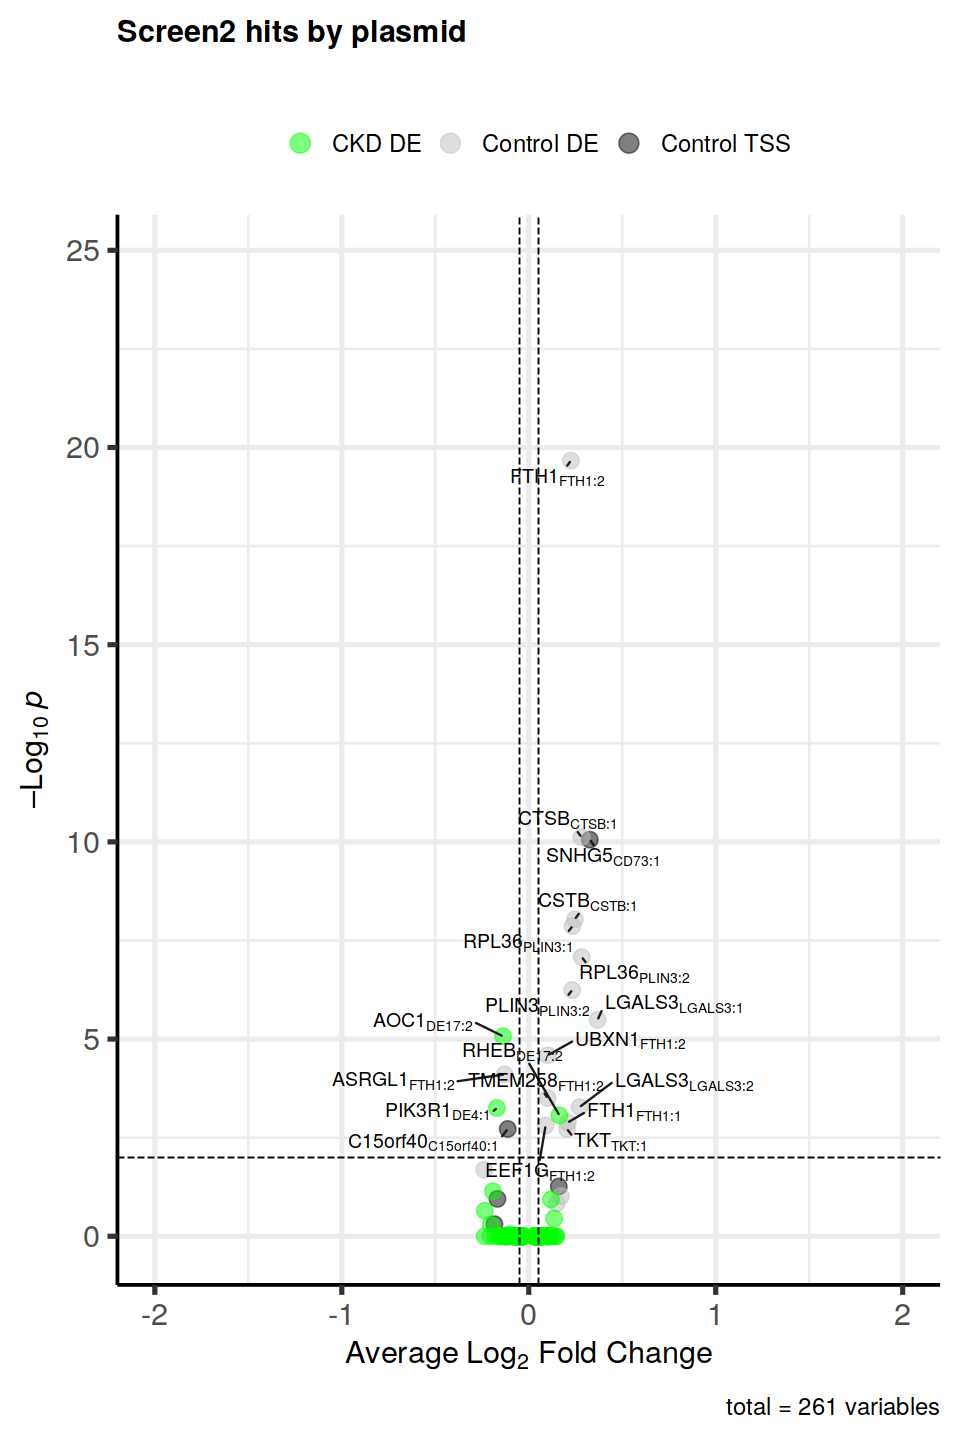

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = annotations,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by plasmid'),
                subtitle = '',
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-3,
                FCcutoff = 0.05,
                pointSize = 4.0,
                labSize = 4.0,
                parseLabels = T
            ) +
            xlim(-2, 2) +
            xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
            ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label
logfc_threshold = 0.01

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


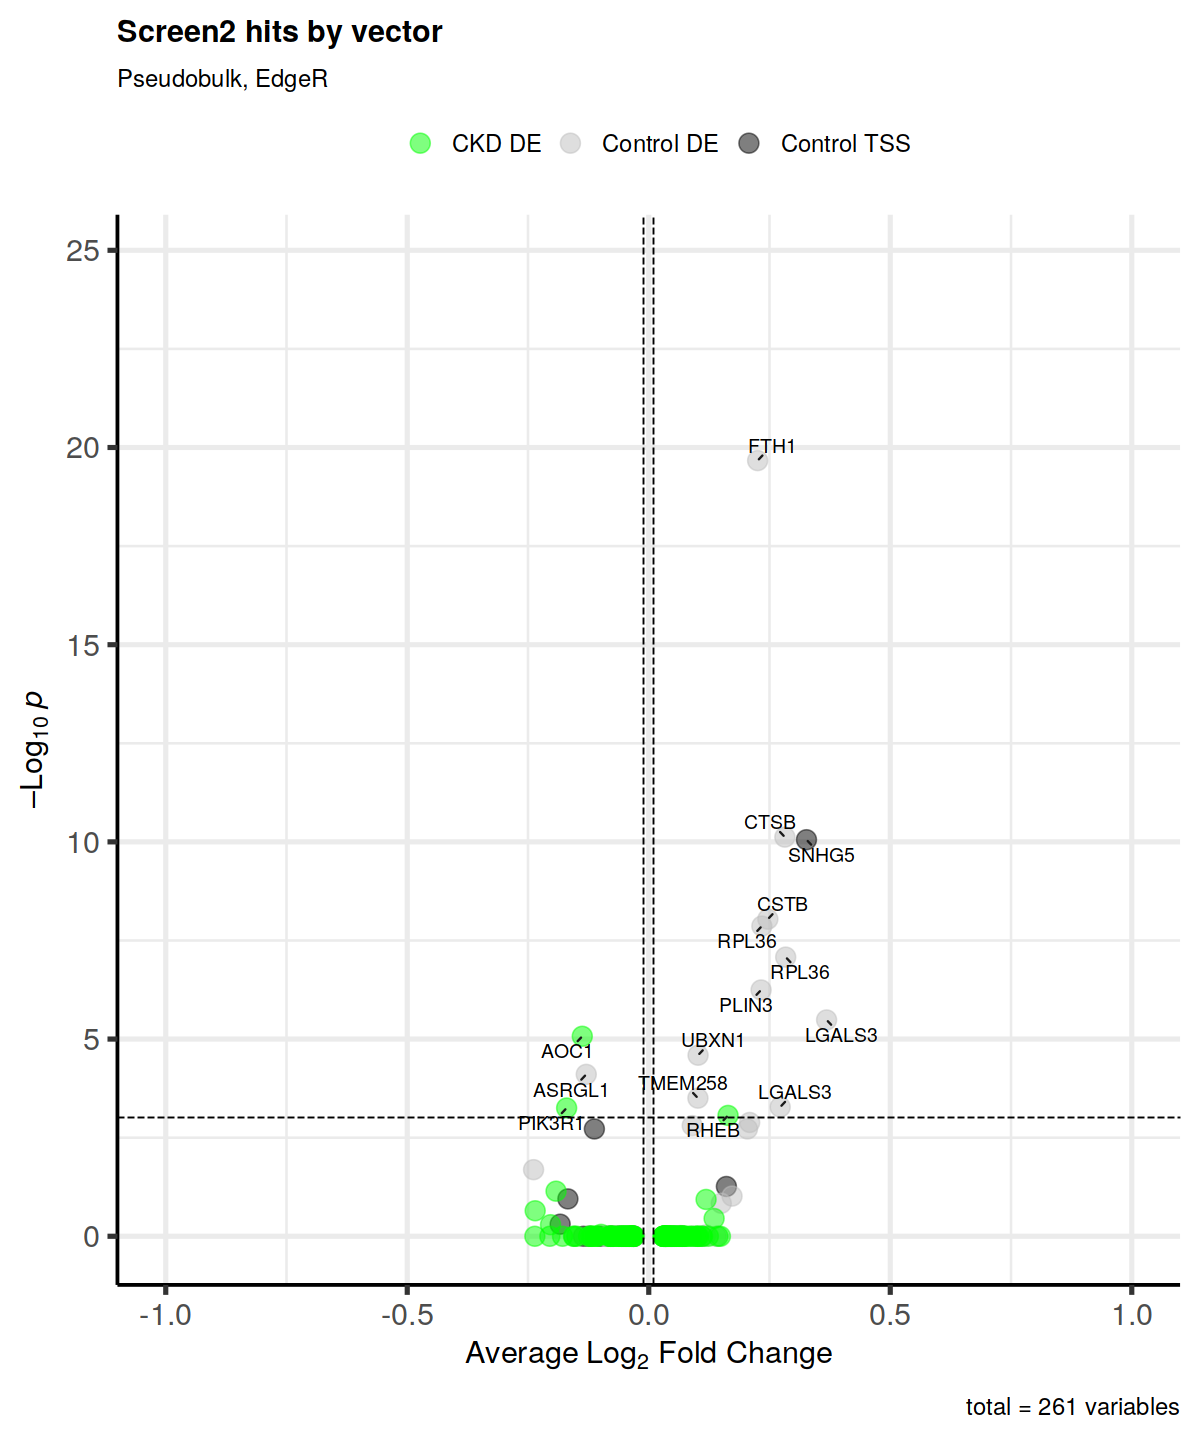

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, "hits by vector"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-04,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


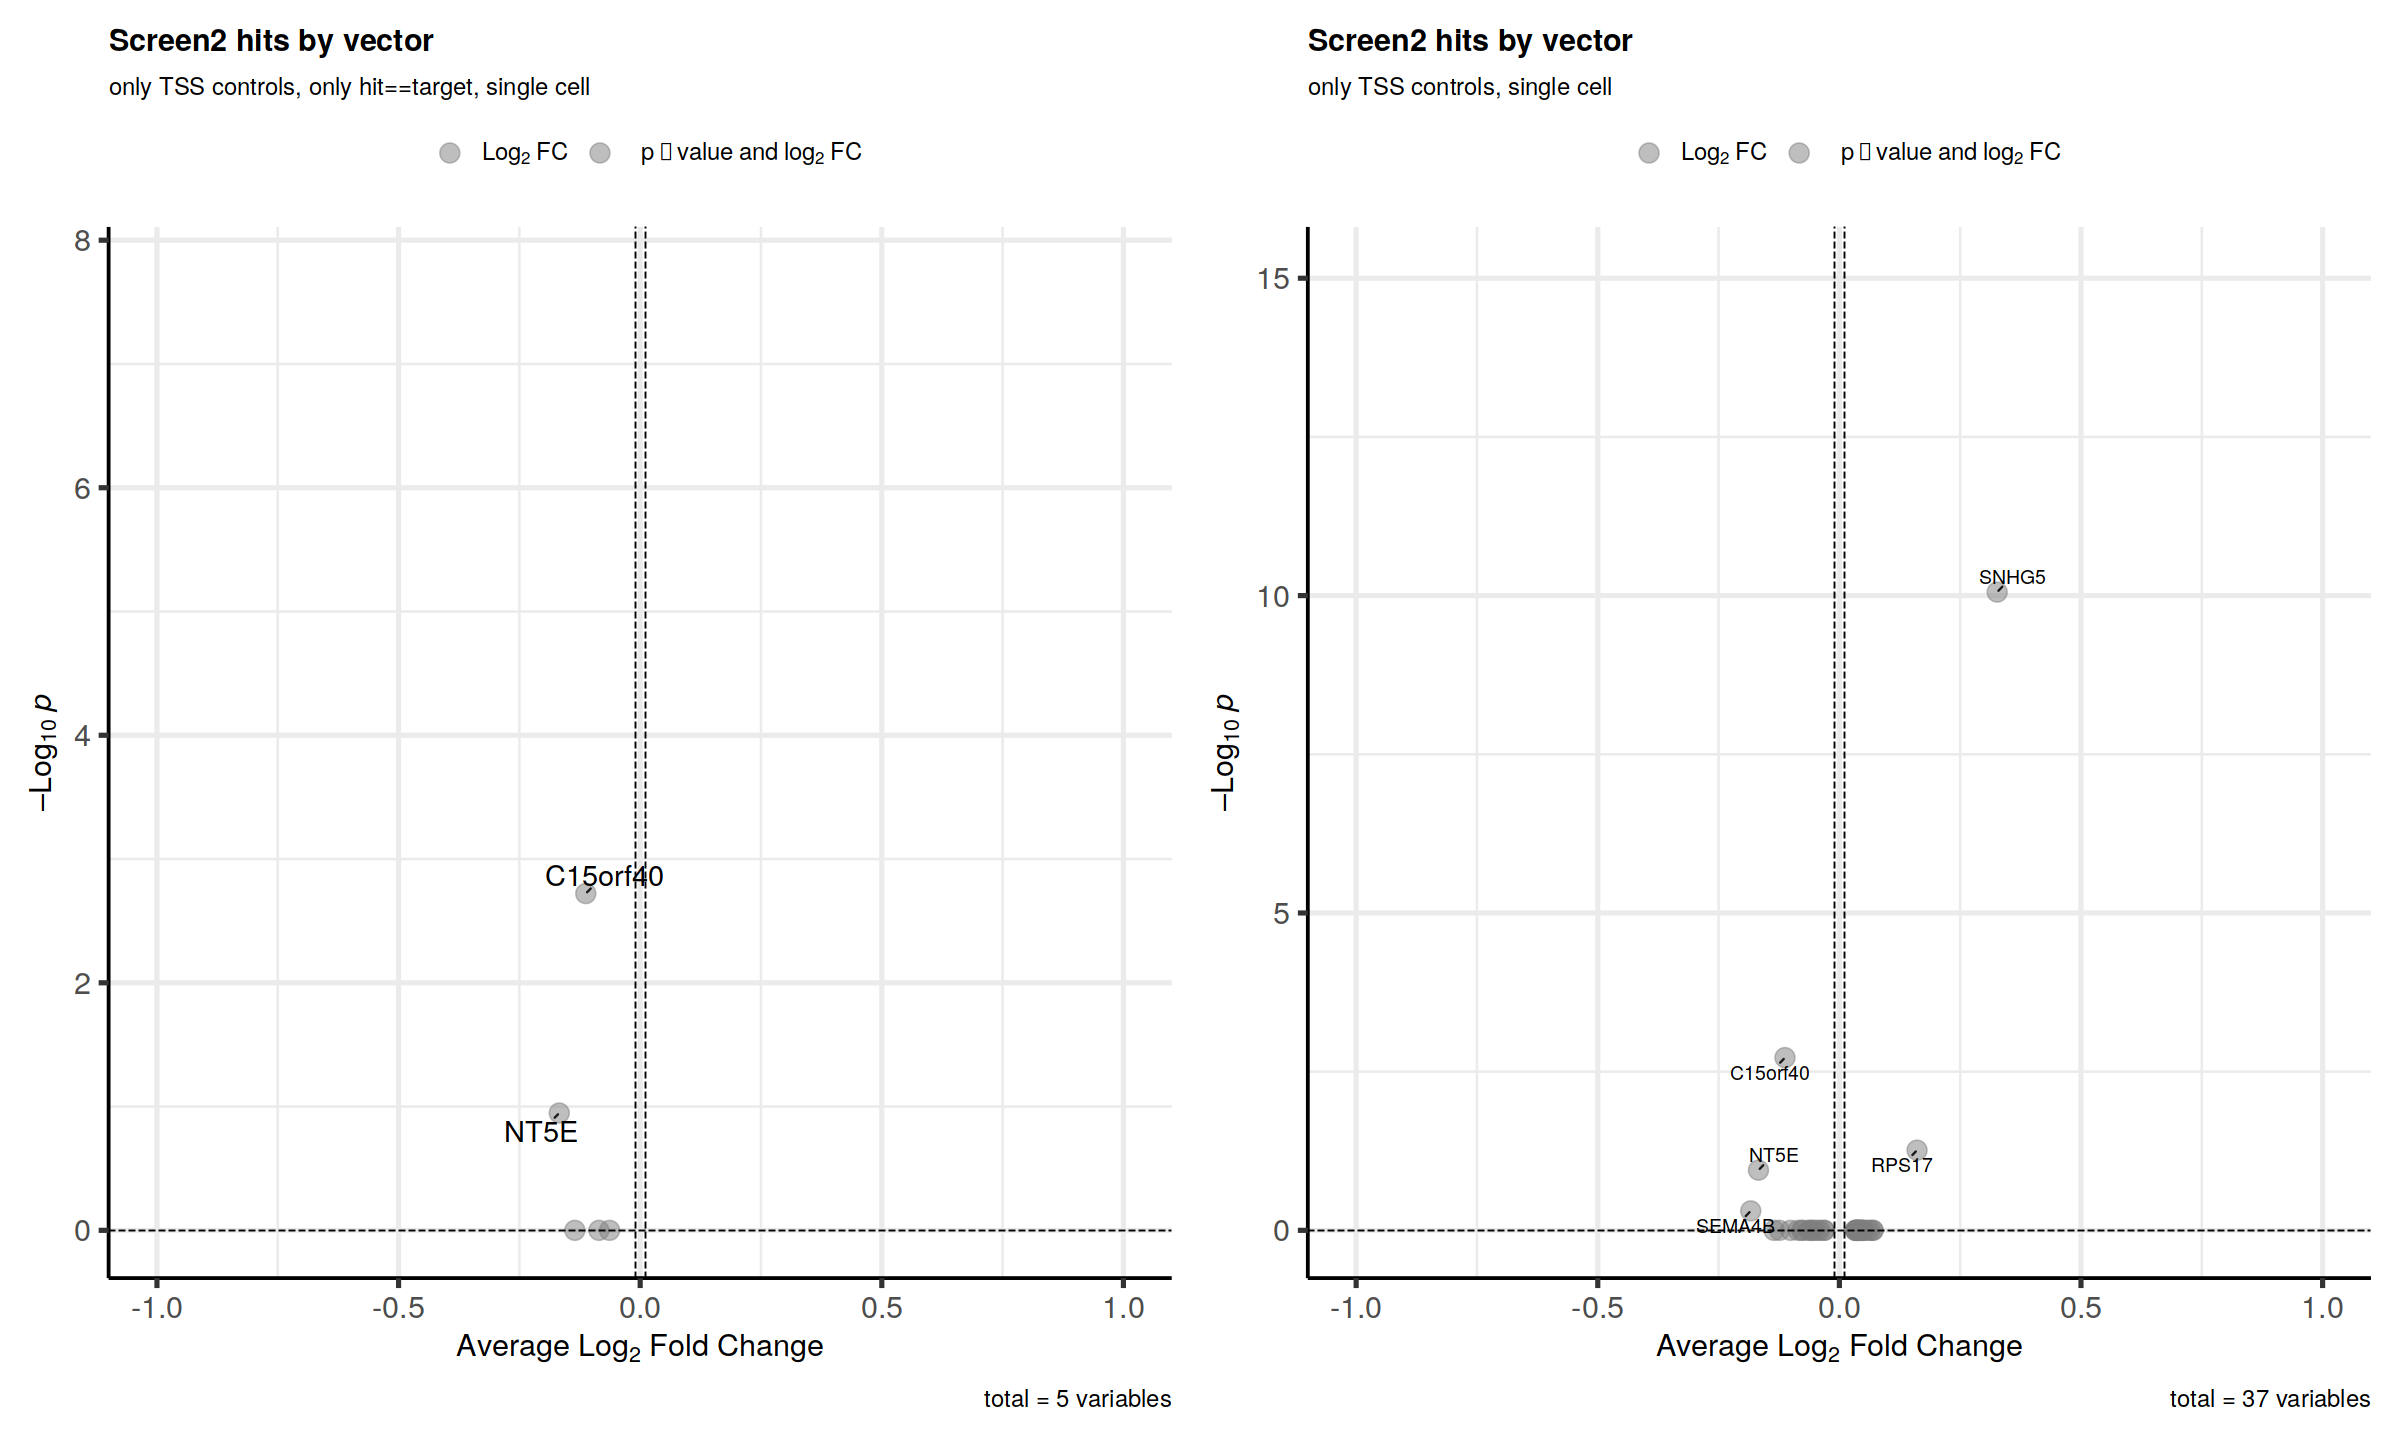

In [ ]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, only hit==target, single cell', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, single cell', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [ ]:
head(df_neighbor_de_subset)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1.3e-05,-0.183,0.76,0.77,0.49,SEMA4B,ANPEP,tss,CD13-1,Control TSS,0.078
2,2.6e-03,0.064,0.65,0.57,1.00,NGRN,ANPEP,tss,CD13-1,Control TSS,1.000
3,4.2e-03,-0.135,0.72,0.72,1.00,ANPEP,ANPEP,tss,CD13-1,Control TSS,1.000
4,5.1e-03,0.047,0.24,0.20,1.00,MESP1,ANPEP,tss,CD13-1,Control TSS,1.000
5,1.6e-02,0.050,0.47,0.39,1.00,MFGE8,ANPEP,tss,CD13-1,Control TSS,1.000
6,3.0e-02,0.044,0.59,0.51,1.00,ABHD2,ANPEP,tss,CD13-1,Control TSS,1.000


### Plot just the control DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


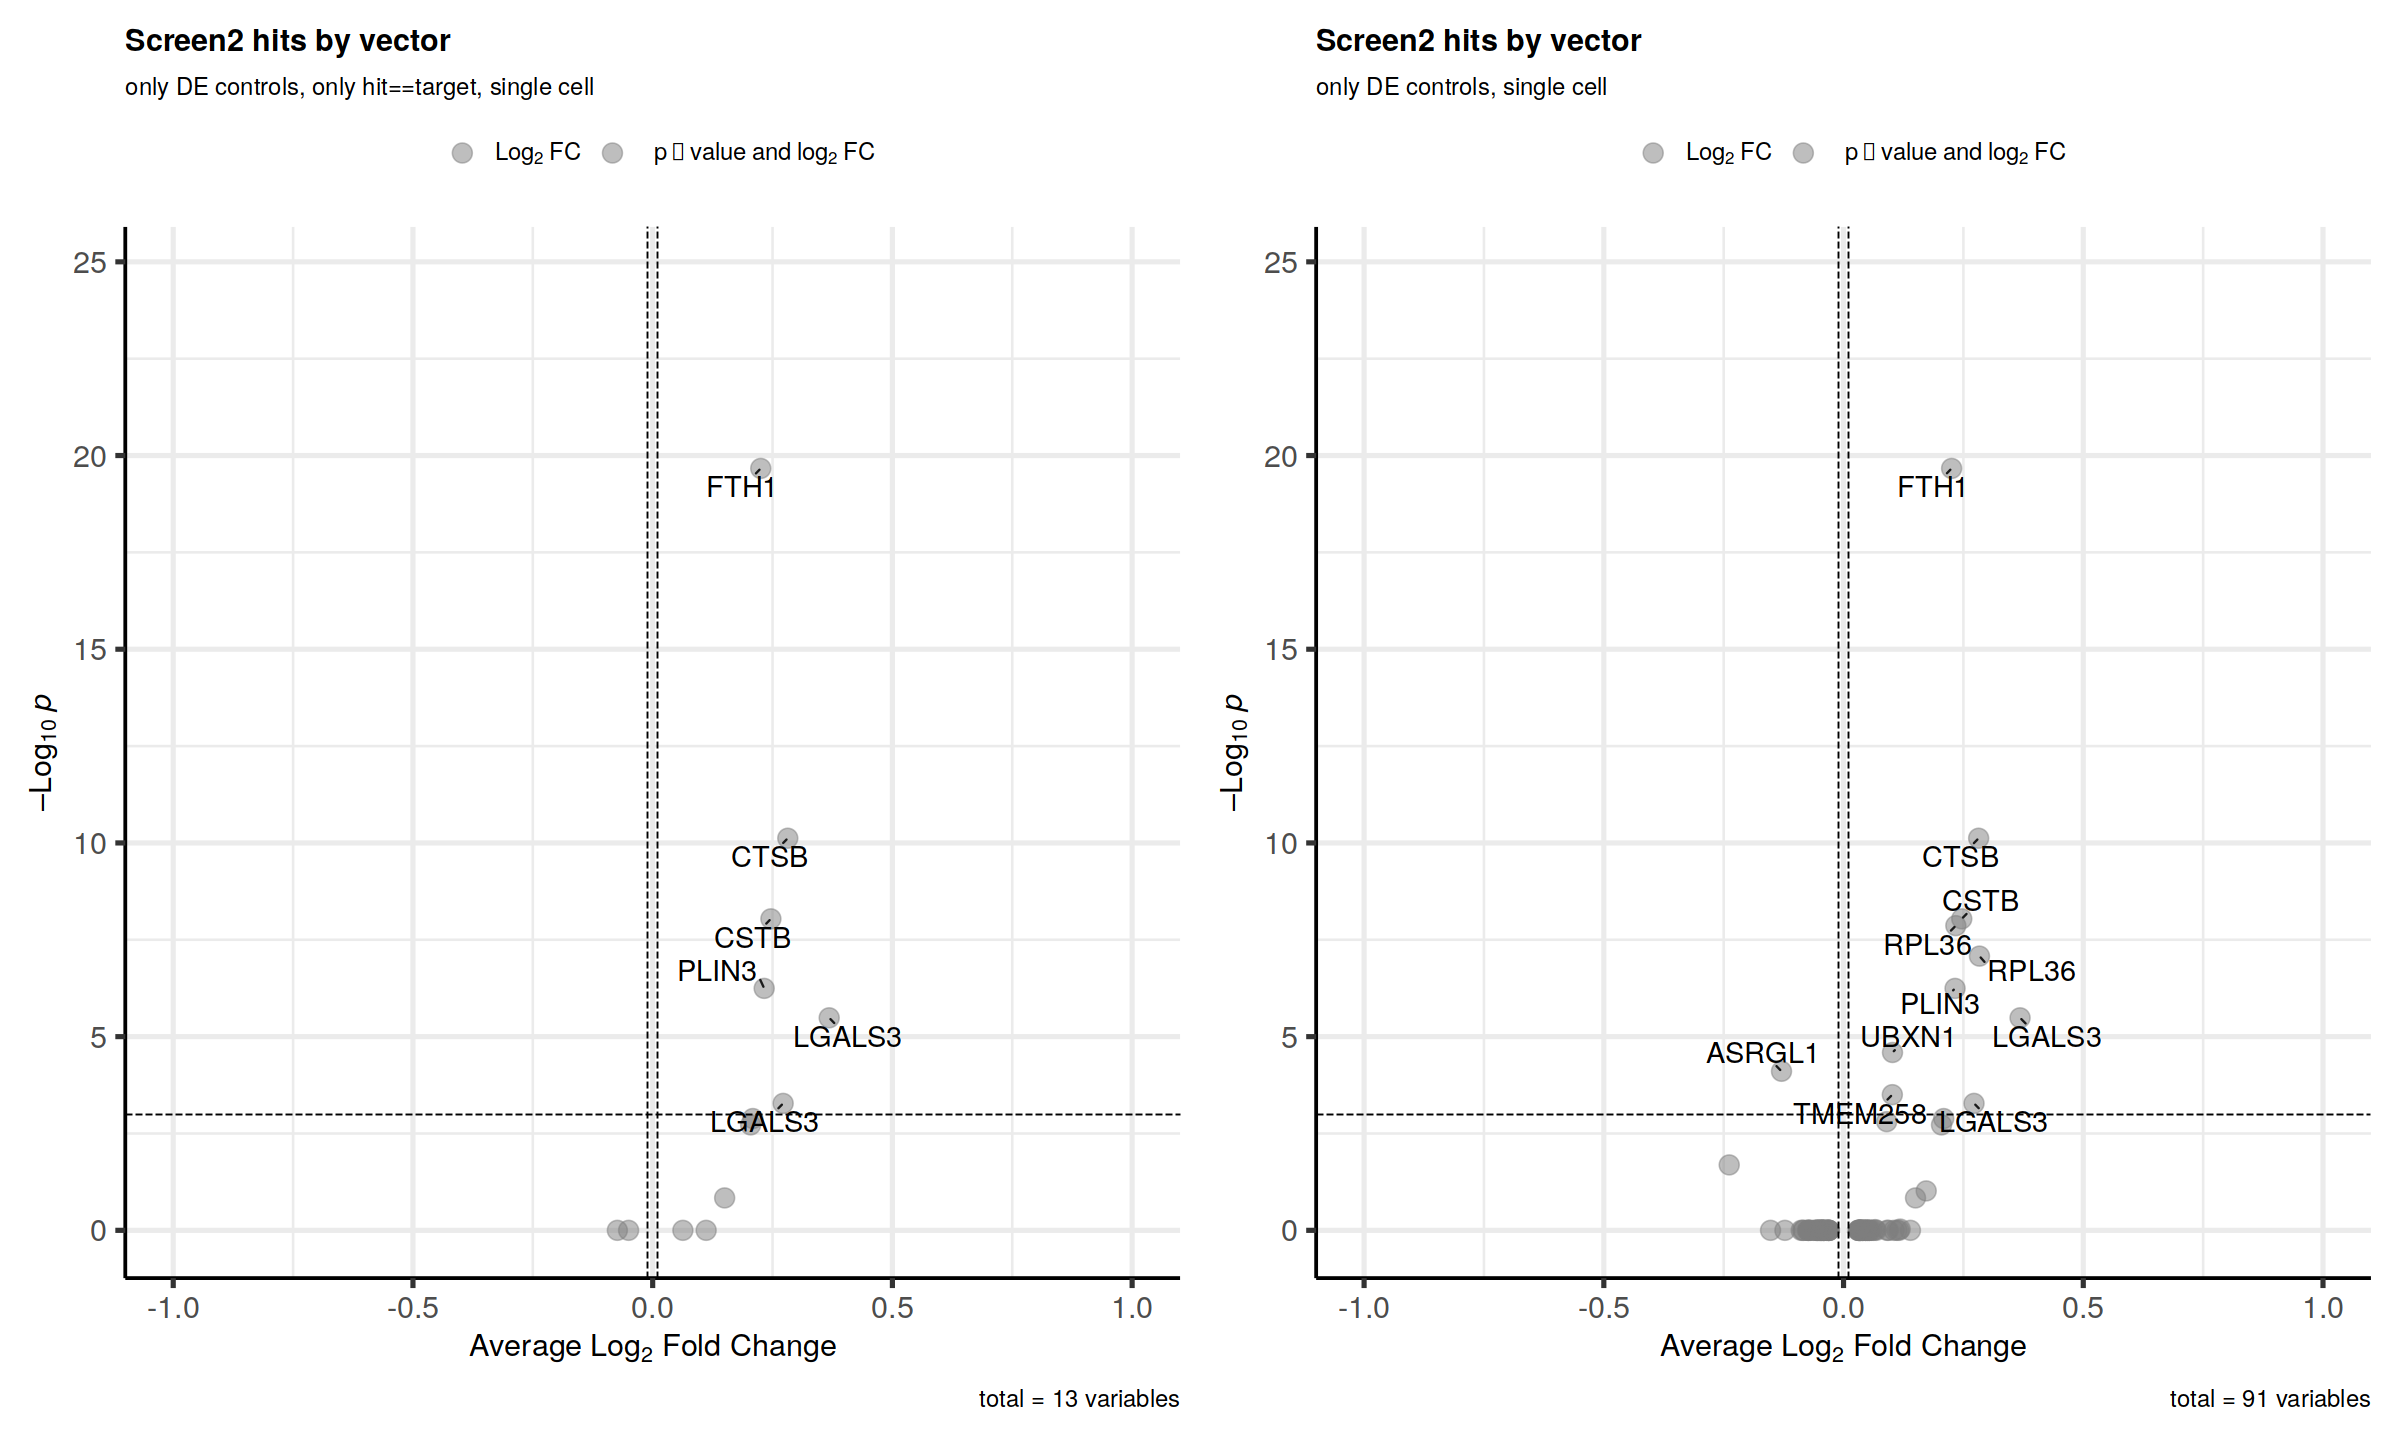

In [ ]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, only hit==target, single cell', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, single cell', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


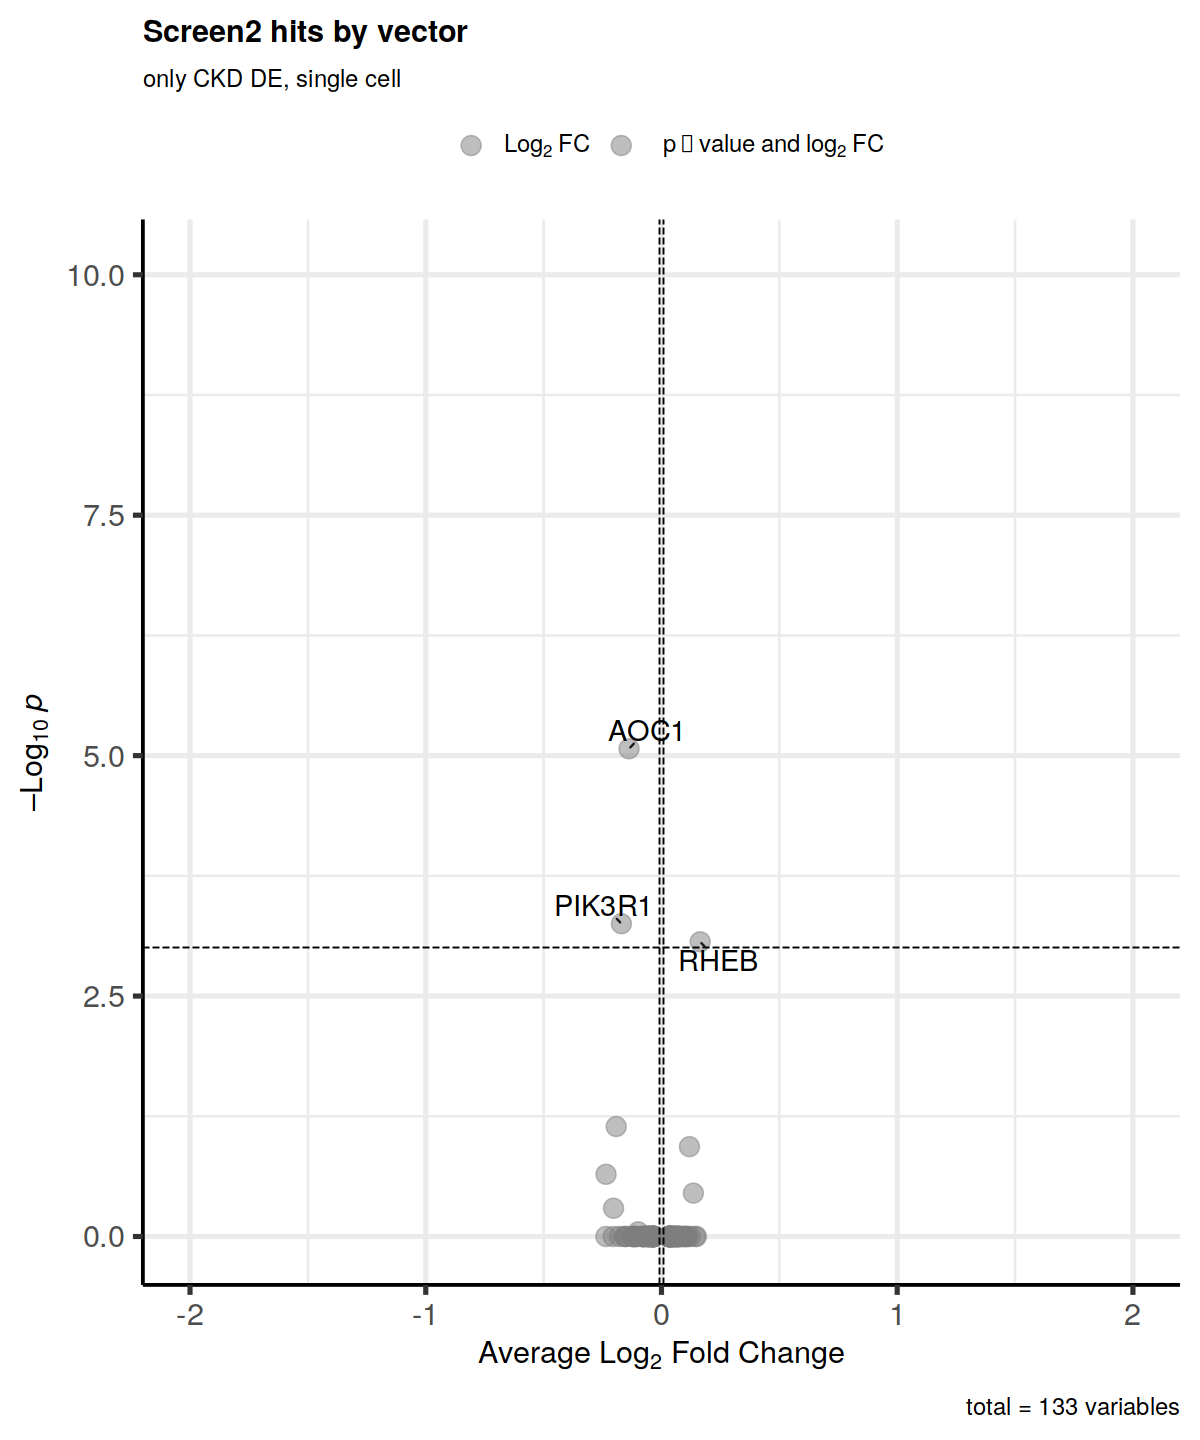

In [ ]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only CKD DE, single cell', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inspect further

In [ ]:
df_neighbor_de %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(25)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,5.9e-25,0.225,1.00,1.00,2.2e-20,FTH1,FTH1,de_control,FTH1-2,Control DE,3.4e-21
2,2.1e-15,0.282,1.00,0.96,7.6e-11,CTSB,CTSB,de_control,CTSB-1,Control DE,1.2e-11
3,2.4e-15,0.327,0.85,0.73,8.8e-11,SNHG5,NT5E,tss,CD73-1,Control TSS,1.4e-11
4,2.5e-13,0.247,0.95,0.93,9.1e-09,CSTB,CSTB,de_control,CSTB-1,Control DE,1.4e-09
5,3.7e-13,0.234,0.99,0.98,1.4e-08,RPL36,PLIN3,de_control,PLIN3-1,Control DE,2.2e-09
6,2.3e-12,0.283,0.99,0.98,8.3e-08,RPL36,PLIN3,de_control,PLIN3-2,Control DE,1.3e-08
7,1.6e-11,0.233,0.74,0.63,5.7e-07,PLIN3,PLIN3,de_control,PLIN3-2,Control DE,9.0e-08
8,8.9e-11,0.368,0.92,0.86,3.3e-06,LGALS3,LGALS3,de_control,LGALS3-1,Control DE,5.2e-07
9,7.0e-10,0.102,0.80,0.75,2.6e-05,UBXN1,FTH1,de_control,FTH1-2,Control DE,4.1e-06


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.4e-15,0.327,0.85,0.73,8.8e-11,SNHG5,NT5E,tss,CD73-1,Control TSS,1.4e-11
2,1.5e-06,0.161,0.97,0.96,5.5e-02,RPS17,C15orf40,tss,C15orf40-1,Control TSS,8.7e-03
3,2.6e-03,0.064,0.65,0.57,1.0e+00,NGRN,ANPEP,tss,CD13-1,Control TSS,1.0e+00
4,5.1e-03,0.047,0.24,0.20,1.0e+00,MESP1,ANPEP,tss,CD13-1,Control TSS,1.0e+00
5,1.6e-02,0.050,0.47,0.39,1.0e+00,MFGE8,ANPEP,tss,CD13-1,Control TSS,1.0e+00
6,3.0e-02,0.044,0.59,0.51,1.0e+00,ABHD2,ANPEP,tss,CD13-1,Control TSS,1.0e+00
7,7.3e-02,0.037,0.43,0.38,1.0e+00,CRTC3,ANPEP,tss,CD13-1,Control TSS,1.0e+00
8,1.7e-01,0.034,0.52,0.48,1.0e+00,SRGAP2,CD55,tss,CD55-1,Control TSS,1.0e+00
9,1.1e-01,0.051,0.79,0.78,1.0e+00,SYNCRIP,NT5E,tss,CD73-1,Control TSS,1.0e+00


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(p_val_adj_mine < 1e-2) %>% arrange(p_val_adj_mine) %>% head(30)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.3e-10,-0.14,0.076,0.17,8.5e-06,AOC1,DE17,ckd_de,DE17-2,CKD DE,1.3e-06
2,1.5e-08,-0.17,0.583,0.61,5.6e-04,PIK3R1,DE4,ckd_de,DE4-1,CKD DE,8.9e-05
3,2.4e-08,0.16,0.879,0.80,8.6e-04,RHEB,DE17,ckd_de,DE17-2,CKD DE,1.4e-04


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (p_val_adj_mine < 1e-10)) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
5.9e-25,0.23,1,1.00,2.2e-20,FTH1,FTH1,de_control,FTH1-2,Control DE,3.4e-21
2.1e-15,0.28,1,0.96,7.6e-11,CTSB,CTSB,de_control,CTSB-1,Control DE,1.2e-11


In [ ]:
#select_significant_p  = df_neighbor_de$p_val_adj_mine < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
152,0.0092,0.031,0.82,0.75,1,NDRG1,DE6,ckd_de,DE6-1,CKD DE,1
153,0.0832,-0.059,0.29,0.31,1,KCNQ3,DE6,ckd_de,DE6-1,CKD DE,1
154,0.6154,-0.051,0.70,0.67,1,ST3GAL1,DE6,ckd_de,DE6-1,CKD DE,1
155,0.0277,-0.079,0.67,0.67,1,ST3GAL1,DE6,ckd_de,DE6-2,CKD DE,1
156,0.0389,-0.048,0.29,0.31,1,KCNQ3,DE6,ckd_de,DE6-2,CKD DE,1
157,0.4045,-0.074,0.76,0.75,1,NDRG1,DE6,ckd_de,DE6-2,CKD DE,1


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
230,4.8e-05,0.123,0.80,0.73,1.000,PPP2CB,DE15,ckd_de,DE15-1,CKD DE,0.279
231,3.0e-03,-0.178,0.97,0.97,1.000,RBPMS,DE15,ckd_de,DE15-1,CKD DE,1.000
232,6.1e-03,0.097,0.79,0.77,1.000,SARAF,DE15,ckd_de,DE15-1,CKD DE,1.000
233,8.0e-02,0.043,0.52,0.48,1.000,DCTN6,DE15,ckd_de,DE15-1,CKD DE,1.000
234,8.4e-02,0.050,0.62,0.57,1.000,LEPROTL1,DE15,ckd_de,DE15-1,CKD DE,1.000
235,3.1e-01,-0.034,0.57,0.58,1.000,GSR,DE15,ckd_de,DE15-1,CKD DE,1.000
236,3.8e-01,-0.032,0.42,0.41,1.000,WRN,DE15,ckd_de,DE15-1,CKD DE,1.000
237,2.0e-06,-0.192,0.97,0.97,0.072,RBPMS,DE15,ckd_de,DE15-2,CKD DE,0.011
238,2.6e-03,0.070,0.79,0.73,1.000,PPP2CB,DE15,ckd_de,DE15-2,CKD DE,1.000


# Debug

In [ ]:
seurat_dummy = seurat_rna
Idents(seurat_dummy) <- "Entire_assay"
select_targeting = df_targeting$subclass == 'tss' | df_targeting$subclass == 'de_control'
target_genes     = df_targeting[select_targeting,]$alias
AverageExpression(seurat_dummy, features = target_genes, slot = 'counts') %>% data.frame() %>% arrange(desc(all))

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



,all
,<dbl>
FTH1,195.78
CTSB,14.48
LGALS3,7.72
CSTB,7.37
TKT,7.02
KLF6,5.38
ANPEP,3.11
NT5E,2.17
PLIN3,1.42


In [ ]:
head(AverageExpression(seurat_dummy, slot = 'counts') %>% data.frame() %>% arrange(desc(all)))

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



,all
,<dbl>
MALAT1,721
MT-CO3,465
MT-CO2,432
MT-CO1,339
MT2A,240
MT-CYB,204


### more debugging

In [ ]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined, df_thresholds)

In [ ]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 425

[1] 425

In [ ]:
length(perturbed_cells_by_guide$'DE6-1b')

[1] 425

In [ ]:
nrow(seurat_combined)

[1] 30056

In [ ]:
unique(seurat_combined$status)

[1] "singlet"

In [ ]:
table(seurat_combined$library)


Lib_1 Lib_2 Lib_3 Lib_4 Lib_5 Lib_6 Lib_7 Lib_8 Lib_9 
 4475  5055  5717  5332  5007  5345  4927  5425  4768 

In [ ]:
length(perturbed_cells_by_guide$'FTH1-1a')

[1] 203

In [ ]:
length(unlist(perturbed_cells_by_guide))

[1] 96792